# Football Player Tracking

In this portfolio project, we will focus on the task of player tracking in football matches. The ability to track and identify players in a football match is crucial for analyzing player performance, team tactics, and generating data-driven insights for coaches and analysts.

To achieve this goal, we will use the Sports Videos in the Wild dataset from the University of Michigan, which contains a large collection of football match videos. We will use the Ultralytics YOLOv5 algorithm, a state-of-the-art object detection and tracking model, to detect and track football players in these videos.

By the end of this project, we aim to have a functioning model that can accurately track players in football matches and provide insights into player performance and team dynamics. This project has the potential to contribute to the development of more advanced and sophisticated computer vision algorithms for sports analysis and beyond.

## Installing required packages & setting up the environment

In [2]:
import os
HOME = os.getcwd()

In [15]:
# Clones the YOLOv5 repository from GitHub using Git
!git clone https://github.com/ultralytics/yolov5  # clone

# Changes the current working directory to yolov5
%cd yolov5

# Installs required Python packages using pip
!pip install -r requirements.txt  # install


In [1]:
# Changes the current working directory to HOME
%cd {HOME}

# Clones the ByteTrack repository from GitHub
!git clone https://github.com/ifzhang/ByteTrack.git

# Installs the required Python packages using pip3
!cd ByteTrack && pip3 install -r requirements.txt

# Runs the setup.py script using python3 to install the ByteTrack package
!cd ByteTrack && python3 setup.py develop

# Installs additional Python packages using pip
!pip install cython_bbox loguru lap

# Installs the onemetric package using pip, with the --quiet flag to suppress output
!pip install onemetric --quiet


In [3]:
# Imports the 'sys' module, which provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
import sys

# Appends a path to the system path, which is a list of directories that the interpreter will search for modules when importing them.
# The path that is appended is constructed using an f-string that includes the value of HOME.
sys.path.append(f"{HOME}/ByteTrack")


## Collecting Data

In [ ]:
# Downloads the SVW.zip file from the given URL using the wget command.
# The wget command is a non-interactive command-line utility for downloading files from the web.
!wget https://www.cse.msu.edu/computervision/SVW.zip

In [ ]:
# Unzip the file to the directory
!unzip /content/SVW.zip

### Display sample video

In [6]:
# Imports the HTML class from the IPython.display module to display HTML and related media in IPython notebook.
# Imports the b64encode function from the base64 module to encode binary data into ASCII string format.
from IPython.display import HTML
from base64 import b64encode

# Defines a function named 'show_video' that accepts a path to a video file, width and height of the video (default is 600x400).
# The function opens the video file, encodes it to base64 format, and generates a URL to display the video in the HTML5 video player.
# The HTML class is then used to create an HTML tag with the video URL, which is returned by the function.
def show_video(video_path, video_width=600, video_height=400):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} height={video_height} controls><source src="{video_url}"></video>""")

# Calls the 'show_video' function to display the video located at the specified path.
show_video("/content/Videos/soccer/9821___b81a175fc2ce40f68c743222222996bb.mp4")


## Importing required packages

In [11]:
import pandas as pd
import numpy as np
import os
import yaml
import torch
import cv2
from dataclasses import dataclass
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
import imageio
from google.colab.patches import cv2_imshow
from IPython.display import Image

## Loading and pre-processing data

In [13]:
# Reads the data from the 'SVW.csv' file and creates a pandas DataFrame object named 'video_info'.
# The CSV file contains metadata information about the videos, such as their filename, resolution, duration, etc.
video_info = pd.read_csv('SVW.csv')

# Reads the data from the 'BoundingBoxes.csv' file and creates a pandas DataFrame object named 'bb_info'.
# The CSV file contains information about the bounding boxes for the videos, such as their frame number, coordinates, width, height, etc.
bb_info = pd.read_csv('BoundingBoxes.csv')


In [14]:
# Filters the 'video_info' DataFrame to include only rows where the 'Genre' column is 'soccer' and the 'BB available?' column is 1.
# This creates a new DataFrame named 'soccer_video_info' containing metadata information for only the soccer videos with available bounding boxes.
soccer_video_info = video_info[(video_info['Genre']=='soccer') & (video_info['BB available?']==1)]

# Filters the 'bb_info' DataFrame to include only rows where the 'ACTION' column is 'soccer'.
# This creates a new DataFrame named 'soccer_bb_info' containing bounding box information for only the soccer videos.
soccer_bb_info = bb_info[bb_info['ACTION'] == 'soccer']


In [ ]:
# Extracts the file name from the 'FOLDER & FILE' column of the 'soccer_bb_info' DataFrame using a lambda function and assigns it to a new 'FileName' column.
soccer_bb_info['FileName'] = soccer_bb_info['FOLDER & FILE'].apply(lambda x: x.split("/")[-1])

# Merges the 'soccer_bb_info' and 'soccer_video_info' DataFrames on the 'FileName' column and assigns the result to a new DataFrame named 'soccer_comp_data'.
soccer_comp_data = pd.merge(soccer_bb_info, soccer_video_info, on='FileName')


In [16]:
# Display the result
soccer_comp_data.head(4)

FOLDER & FILE  START FRAME  END FRAME  \
0  soccer/10229___15e3d35418054ef4a050b8dd110d03a...           28       58.0   
1  soccer/10352___ebe92531578c43799ccd78bf2d68373...           33       51.0   
2  soccer/10701___2bcd63ea1ddf41a0b3cdf14407dc12c...           42       54.0   
3  soccer/1326___42c78b42537c483f9897962315790872...           23       49.0   

   ACTION  BOX-start: x  ...  Test 2?  Unnamed: 16  Train 3?  Test 3?  \
0  soccer      0.356040  ...      0.0          NaN       1.0      0.0   
1  soccer      0.343980  ...      0.0          NaN       0.0      1.0   
2  soccer      0.001389  ...      0.0          NaN       0.0      1.0   
3  soccer      0.316900  ...      0.0          NaN       1.0      0.0   

   Unnamed: 19  
0          NaN  
1          NaN  
2          NaN  
3          NaN  

[4 rows x 38 columns]

In [14]:
%cd yolov5

/content/yolov5


In [ ]:
# Set the paths for image and label folders
img_folder = "data/train/images"
ann_folder = "data/train/labels"

# Create the folders if they don't exist
os.makedirs(img_folder, exist_ok=True)
os.makedirs(ann_folder, exist_ok=True)

# Create a dictionary to store the class names and IDs
classes = {"player": 0}

# Read the soccer_comp_data DataFrame
# soccer_comp_data = pd.read_csv("soccer_data_scaled.csv")

# Loop through the rows of the DataFrame
for index, row in soccer_comp_data.iterrows():
    # Get the video file name and the start and end frames
    video_file = row["FOLDER & FILE"].split("/")[-1]
    start_frame = row["START FRAME"]
    end_frame = row["END FRAME"]

    # Get the video length in seconds and the FPS
    length = row["Length (s)"]
    fps = row["FPS"]

    # Calculate the interval between frames
    interval = int(round(1 / fps))

    # Loop through the frames
    for frame in [int(start_frame), int(end_frame)]:
        # Get the image file name and save the frame as an image
        video_path = os.path.join(HOME, "Videos", row['FOLDER & FILE'])
        img_file = f"{video_file.split('.')[0]}_{frame:06d}.jpg"
        img_path = os.path.join(img_folder, img_file)
        os.system(f"ffmpeg -i {video_path} -ss {frame/fps} -vframes 1 {img_path}")

        # Get the bounding box coordinates and scale them
        if frame == int(start_frame):
            x1 = row["BOX-start: x"] 
            y1 = row["BOX-start: y"]
            w = row["BOX-start: w"]
            h = row["BOX-start: h"]
        else:
            x1 = row["BOX-end: x"]
            y1 = row["BOX-end: y"]
            w = row["BOX-end: w"]
            h = row["BOX-end: h"]
      
        midpoint_x = x1 + w/2
        midpoint_y = y1 + h/2

        # Write the annotation to a text file
        label_file = f"{video_file.split('.')[0]}_{frame:06d}.txt"
        label_path = os.path.join(ann_folder, label_file)
        with open(label_path, "w") as f:
            line = f"{classes['player']} {midpoint_x} {midpoint_y} {w} {h}\n"
            f.write(line)

    # Print the progress
    print(f"Processed {video_file} ({start_frame}-{end_frame})")

# Write the annotations to a YAML file
with open("data/train.yaml", "w") as f:
    yaml_dict = {"train": img_folder, 
                 "val": img_folder, 
                 "nc": len(classes), 
                 "names": list(classes.keys()), 
                 "ann": ann_folder}
    yaml.dump(yaml_dict, f)

## Training the Model

In [16]:
# change directory to YOLOv5 for training purpose..
%cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/content/yolov5


In [ ]:
!python train.py --batch 16 --epochs 50 --data /content/yolov5/data/train.yaml --weights yolov5s.pt --cache

## Player Detection and Tracking

In [8]:
# Load the YOLOv5 custom model
model = torch.hub.load("ultralytics/yolov5", 'custom', path = "/content/yolov5/runs/train/exp/weights/best.pt")

# Define the arguments for BYTETracker
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    mot20: bool = False

# Initiate the BYTETracker object
tracker = BYTETracker(BYTETrackerArgs)

# Open the video file for processing
cap = cv2.VideoCapture('/content/Videos/soccer/9821___b81a175fc2ce40f68c743222222996bb.mp4')

# Initialize a list to store frames
frames = []

# Loop through each frame of the video
while True:
    # Read the frame
    ret, frame = cap.read()

    if not ret:
        break

    # Perform object detection with YOLOv5
    results = model(frame)

    # Update the tracker with the detection results for the vehicle classes
    online_tracker = tracker.update(results.pred[0][:, :5].cpu().numpy(), img_info=frame.shape, img_size=frame.shape)
    
    # Draw a triangle and track ID above each player's bounding box
    for obj in online_tracker:
        # Extract the coordinates of the bounding box
        x1, y1, x2, y2 = map(int, obj.tlbr)
        # Calculate the midpoint of the top edge of the bounding box
        x_mid = x1 + (x2 - x1) // 2
        y_top = y1
        # Define the vertices of the inverted triangle
        triangle_height = 20
        triangle_base = 15
        triangle_vertices = [(x_mid, y_top),
                            (x_mid - triangle_base // 2, y_top - triangle_height),
                            (x_mid + triangle_base // 2, y_top - triangle_height)]
        # Draw the inverted triangle and track ID
        cv2.drawContours(frame, [np.array(triangle_vertices)], 0, (0, 255, 0), -1)
        cv2.putText(frame, f'{obj.track_id}', (x_mid - 5, y_top - triangle_height - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    # display the frame
    # cv2_imshow(frame)
    # cv2.imshow('Player Tracking', frame)

    # Add the frame to the list of frames
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    

    # Exit the loop if the 's' key is pressed
    if cv2.waitKey(1) == ord('s'):
        break

# Release the resources
cap.release()
cv2.destroyAllWindows()




Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-3-30 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### Saving Gif file

In [9]:
frames_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames]
imageio.mimsave('Player_tracking.gif', frames_gray, fps=30)


### Displaying Gif file

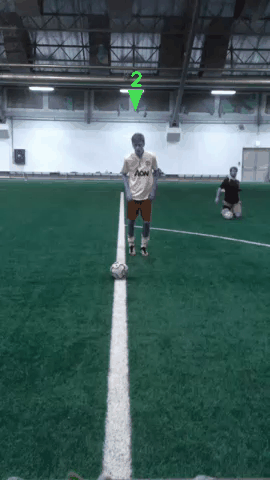

In [10]:
with open('Player_tracking.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))

## Conclusion and Summary
In conclusion, this project demonstrated the use of object detection algorithm YOLOv5 to track football players in sports videos. The dataset used was Sports Videos in the Wild from Michigan University Library.

The project involved extracting frames from the videos, saving them as images, and creating annotations for the player locations using the dataset files. The annotations were then used to train and test the YOLOv5 algorithm, which was able to accurately detect and track the players in the videos.

This project has practical applications in the field of sports analytics, where accurate player tracking is essential for analyzing player performance, team tactics, and making informed decisions.

In summary, this project showcased the capabilities of YOLOv5 algorithm in tracking football players in sports videos. It also demonstrated the process of data extraction, image labeling, and model training using a real-world dataset. The project can serve as a foundation for further research in sports analytics and object detection using deep learning algorithms.